In [1]:
import numpy as np
import matplotlib.pyplot as plt
import general_functions
import scipy.stats

One buy, one sell, one interest payment. Assume ideal transactions. Ignore inflation.

### Parameters

In [2]:
steps = 100

### Simulation - Smart loan

In [3]:
def smart_loan(p, d, m, r):
    return np.maximum(p - r * d, 0)


def simple_loan(p, d, m, r):
    p_seller = np.random.uniform(0.1 * p, 10 * p)
    return np.maximum(p_seller - m, 0)


def simulation(alpha, r, loan_size_func):
    # Initial values
    m = 1
    p = 1
    d = 0

    m_hist = []
    p_hist = []
    d_hist = []

    went_bankrupt = False

    for _ in range(steps):    
        # Buy. First take loan, find bought amount, update values
        loan_size = loan_size_func(p, d, m , r) 
        d += loan_size
        m += loan_size    

        B = m
        p += alpha * B 
        m = 0
        
        # Sell
        m += p
        
        # Interest payment
        m -= r * d
        
        if m + p < r * d:
            went_bankrupt = True
        
        # Store values
        m_hist.append(1 * m)
        p_hist.append(1 * p)
        d_hist.append(1 * d)

    print("Went bankrupt:", went_bankrupt)
    
    # Plot        
    fig, (ax, ax1) = plt.subplots(nrows=2)
    ax.plot(p_hist, label="p")
    ax.plot(d_hist, label="d")
    ax.plot(m_hist, label="m")
    ax.set(ylabel="log $", title=fr"{loan_size_func.__name__} $\alpha=${alpha}, $r=${r}", yscale="log")
    ax.legend()
    
    ax1.plot(np.array(p_hist) + np.array(m_hist), label="Worth", alpha=0.7, color="green")
    ax1.plot(r * np.array(d_hist), label="Bankruptcy limit", alpha=0.7, color="orange", ls="dotted")
    ax1.set(xlabel="Time", ylabel="log $",yscale="log")
    ax1.legend()
    plt.show()

## Simulation - simple loan

Assume $p_i \sim \mathcal{U} [0.1 p_j, 10p_j]$. 

Went bankrupt: False


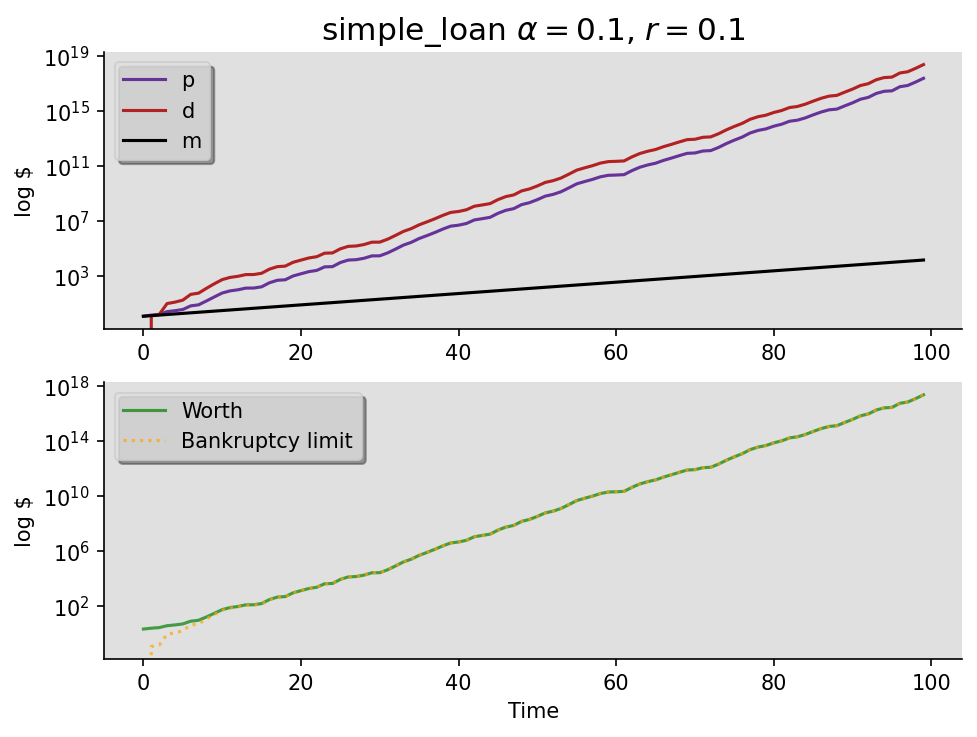

Went bankrupt: False


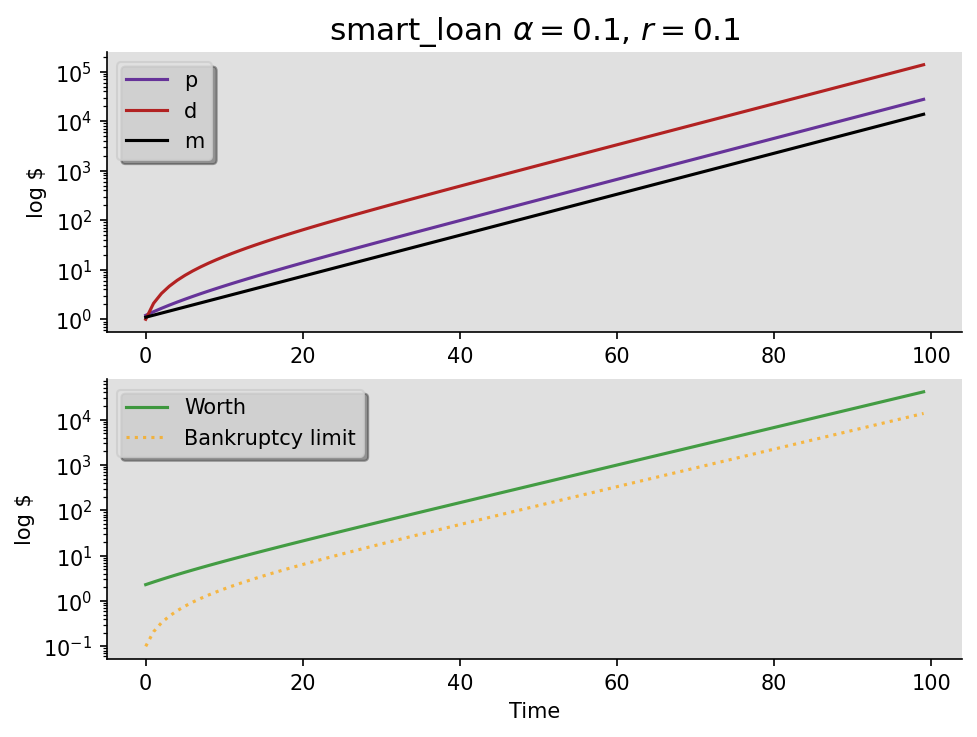

In [4]:
alpha = 0.1
r = 0.1
simulation(alpha, r, loan_size_func=simple_loan)
simulation(alpha, r, loan_size_func=smart_loan)

# Include chance to not sell or sell twice

In [5]:
def simulation_double_or_none(alpha, r, loan_size_func, store_value):
    # Initial values
    m = 1
    p = 1
    d = 0

    m_hist = []
    p_hist = []
    d_hist = []

    went_bankrupt = False

    # Probabilities to sell twice or none
    N_company = 100
    rv = scipy.stats.binom(n=N_company, p=1/N_company)
    
    prob_two_instances = rv.pmf(k=2)
    prob_zero_instances = rv.pmf(k=0)
    prob_not_zero_but_two_instances = prob_two_instances / (1 - prob_zero_instances)
    
    for _ in range(steps):    
        # Buy. First take loan, find bought amount, update values
        loan_size = loan_size_func(p, d, m , r) 
        d += loan_size
        m += loan_size    

        B = np.maximum(m, 0)
        p += alpha * B 
        m = 0
        
        # Sell. 
        if np.random.uniform() < prob_zero_instances: 
            pass # No sell
        elif np.random.uniform() < prob_not_zero_but_two_instances:
            m += 2 * p  # Twice sell
        else:
            m += p  # One sell
        
        # Interest payment
        m -= r * d
        
        if m + p < r * d:
            went_bankrupt = True
        
        # Store values
        m_hist.append(1 * m)
        p_hist.append(1 * p)
        d_hist.append(1 * d)
    
    if store_value: 
        return went_bankrupt
    else:
        print("Went bankrupt:", went_bankrupt)
        
        # Plot        
        fig, (ax, ax1) = plt.subplots(nrows=2)
        ax.plot(p_hist, label="p")
        ax.plot(d_hist, label="d")
        ax.plot(m_hist, label="m")
        ax.set(ylabel="log $", title=fr"{loan_size_func.__name__} $\alpha=${alpha}, $r=${r}", yscale="log")
        ax.legend()
        ax.grid()
        
        ax1.plot(np.array(p_hist) + np.array(m_hist), label="Worth", alpha=0.7, color="green")
        ax1.plot(r * np.array(d_hist), label="Bankruptcy limit", alpha=0.7, color="orange", ls="dotted")
        ax1.set(xlabel="Time", ylabel="log $",yscale="log")
        ax1.legend()
        ax1.grid()
        plt.show()

Went bankrupt: True


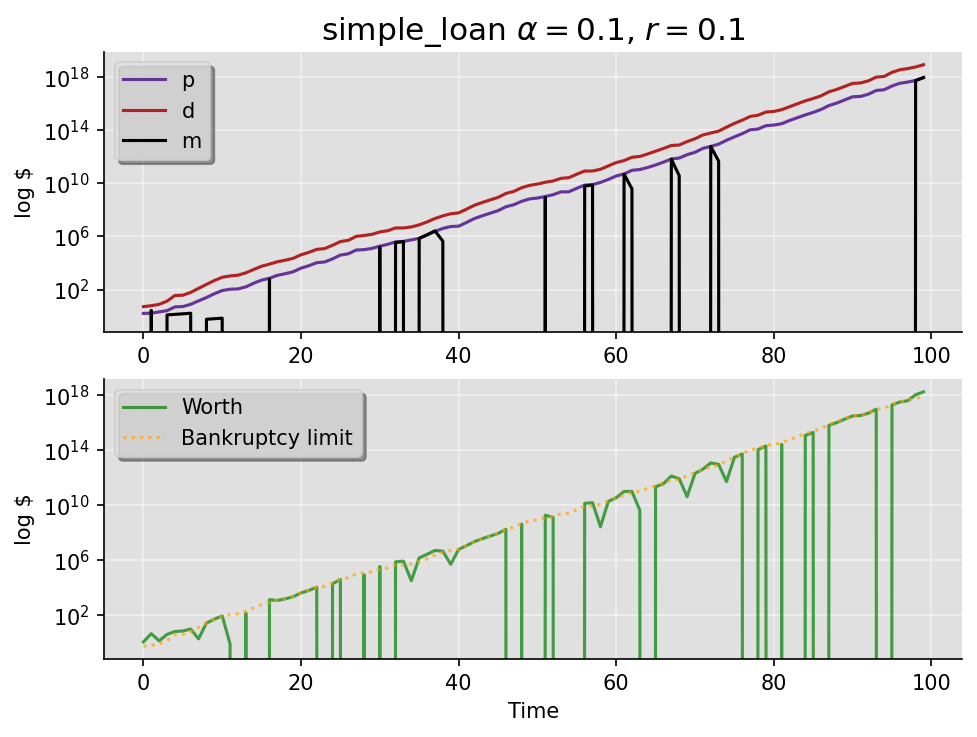

Went bankrupt: True


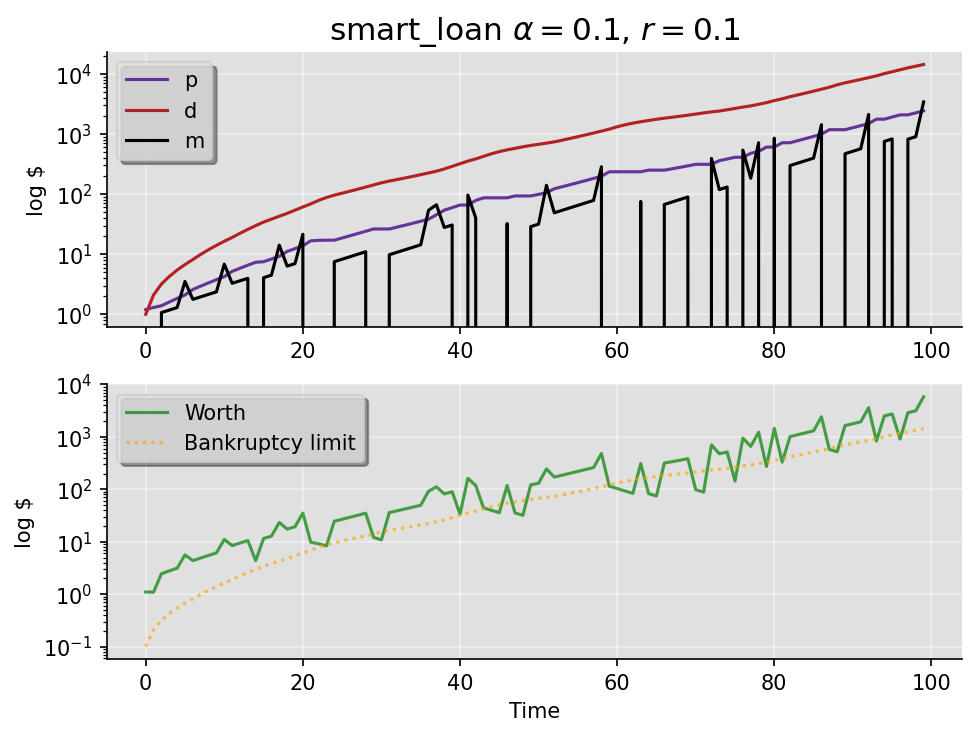

In [6]:
simulation_double_or_none(alpha, r, loan_size_func=simple_loan, store_value=False)
simulation_double_or_none(alpha, r, loan_size_func=smart_loan, store_value=False)

## plot bankruptices vs alpha / r

In [9]:
def bankruptcy_vs_alpha_r(N_repeats, alpha_vals, r):
    N_simple = np.empty((len(alpha_vals), N_repeats))
    N_smart = np.empty((len(alpha_vals), N_repeats))
    
    for i in range(N_repeats):
        for j, alpha in enumerate(alpha_vals):
            went_bankrupt_simple = simulation_double_or_none(alpha=alpha, r=r, loan_size_func=simple_loan, store_value=True)
            went_bankrupt_smart = simulation_double_or_none(alpha=alpha, r=r, loan_size_func=smart_loan, store_value=True)
            
            N_simple[j, i] = went_bankrupt_simple
            N_smart[j, i] = went_bankrupt_smart
    
    mean_simple = np.mean(N_simple, axis=1)
    mean_smart = np.mean(N_smart, axis=1)
    std_simple = np.std(N_simple, axis=1, ddof=1)
    std_smart = np.std(N_smart, axis=1, ddof=1)
    
    return mean_simple, mean_smart, std_simple, std_smart


def plot_bankruptcy(N_repeats, alpha_vals, r=0.01):
    mean_simple, mean_smart, std_simple, std_smart = bankruptcy_vs_alpha_r(N_repeats, alpha_vals, r)
    fig, ax = plt.subplots()
    ax.errorbar(alpha_vals/r, mean_simple, yerr=std_simple, fmt=".-", label="Simple", alpha=0.8)
    ax.errorbar(alpha_vals/r, mean_smart, yerr=std_smart, fmt=".--", label="Smart", alpha=0.8)
    ax.set(xlabel=r"$\alpha$/r", ylabel="Probability of bankruptcy", title="Bankruptcies for Simple and Smart loan strategy")
    ax.legend()
    plt.show()

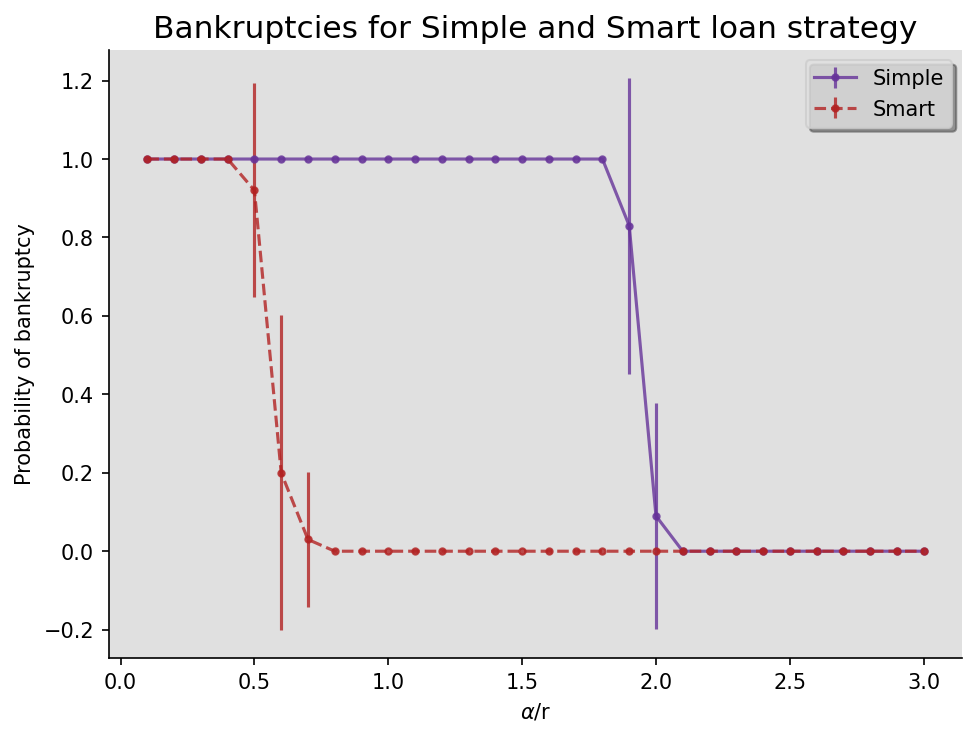

In [11]:
plot_bankruptcy(N_repeats=100, alpha_vals=np.linspace(0.001, 0.03, num=30), r=0.01)